# GO Catalytic Activity Text Definition Analysis

Here we try and do two things

 * If we have a formulaic text definition for an activity in GO, parse it
 * If we have a parsed text definition AND a RHEA xref, compare the two
 
 The reports for this analysis are in https://github.com/cmungall/reactioner/tree/master/reports
 
## Parsing Text Definitions

We assume a CA text def is of the form

 * **Activity** `::=` "Catalysis of the reaction:" **Participants** Operator **Participants**
 * **Operator** `::=` "=" | "<=" | "=>" | "<=>"
 * **Participants** `::=` **Participant** [" + " **Participant**]*
 * **Participant** `::=` {**Quantifier**} **ChemicalName** {**Modifier**}
 
After parsing, the **ChemicalNames** are *matched* to CHEBI IDs using basic Named Entity Recognition (NER). As there are multiple potential matches, there can be a combinatorial number of parses (e.g. with 4 participants, if each participant matches 2 CHEBI IDs, there will be 16 parses). We score each parse based on how the GO participant name matches to CHEBI one. For each match, the following are applied in precendence order:

 * if it matches a syn (related or exact, these are undistinguished in CHEBI), **AND** one of the axiom annotations is to UniProt **highest score**
 * If it matches a label, **next highest score**
 * if it matches a syn (related or exact, these are undistinguished in CHEBI), **moderate score**
 * Otherwise, **penalty score**
 


In [54]:
## Import libraries and methods
import seaborn as sns
sns.set(style="whitegrid")

import pandas as pd
from notebook_utils import create_venn, create_upset
%matplotlib inline

In [55]:
## Fetch xref data and set up DBs
## File available in GitHub, see https://github.com/cmungall/reactioner/tree/master/reports
df = pd.read_csv("reports/go-rhea-check.tsv", sep="\t").fillna("")
## Show sample
df

,class,class label,def,op,goleft,goright,rhea,rhea label,direction,is_match,score,info,info label
0,GO:0004133,glycogen debranching enzyme activity,Catalysis of the cleavage of branch points in ...,,,,,,,,,,
1,GO:0009975,cyclase activity,Catalysis of a ring closure reaction.,,,,,,,,,,
2,GO:0010280,UDP-L-rhamnose synthase activity,Catalysis of the reaction: UDP-D-glucose + NAD...,,,,,,,,,,
3,GO:0016491,oxidoreductase activity,Catalysis of an oxidation-reduction (redox) re...,,,,,,,,,,
4,GO:0016740,transferase activity,"Catalysis of the transfer of a group, e.g. a m...",,,,,,,,,,
5,GO:0016787,hydrolase activity,"Catalysis of the hydrolysis of various bonds, ...",,,,,,,,,,
6,GO:0016829,lyase activity,"Catalysis of the cleavage of C-C, C-O, C-N and...",,,,,,,,,,
7,GO:0016853,isomerase activity,Catalysis of the geometric or structural chang...,,,,,,,,,,
8,GO:0016874,ligase activity,"Catalysis of the joining of two substances, or...",,,,,,,,,,
9,GO:0032451,demethylase activity,Catalysis of the removal of a methyl group fro...,,,,,,,,,,


## Sample of parsed matching text defs


In [56]:
df.loc[df['is_match'] == 'matched']

,class,class label,def,op,goleft,goright,rhea,rhea label,direction,is_match,score,info,info label
18,GO:0004016,adenylate cyclase activity,"Catalysis of the reaction: ATP = 3',5'-cyclic ...",=,http://purl.obolibrary.org/obo/CHEBI_30616/ATP...,"http://purl.obolibrary.org/obo/CHEBI_58165/3',...",rh:15389,"ATP = 3',5'-cyclic AMP + diphosphate",g,matched,66,,
19,GO:0004383,guanylate cyclase activity,"Catalysis of the reaction: GTP = 3',5'-cyclic ...",=,http://purl.obolibrary.org/obo/CHEBI_37565/GTP...,"http://purl.obolibrary.org/obo/CHEBI_57746/3',...",rh:13665,"GTP = 3',5'-cyclic GMP + diphosphate",g,matched,66,,
24,GO:0035439,halimadienyl-diphosphate synthase activity,Catalysis of the reaction: geranylgeranyl diph...,=,http://purl.obolibrary.org/obo/CHEBI_57533/ger...,"http://x.org/noparse#halima-5(6),13-dien-15-yl...",rh:25621,geranylgeranyl diphosphate = tuberculosinyl di...,g,matched,-42,"halima-5(6),13-dien-15-yl diphosphate=http://p...",
28,GO:0046423,allene-oxide cyclase activity,"Catalysis of the reaction: (9Z,13S,15Z)-12,13-...",=,http://purl.obolibrary.org/obo/CHEBI_36438/(9Z...,http://purl.obolibrary.org/obo/CHEBI_57411/(15...,rh:22592,"(9Z,13S,15Z)-12,13-epoxyoctadeca-9,11,15-trien...",g,matched,70,,
29,GO:0047768,"carboxy-cis,cis-muconate cyclase activity","Catalysis of the reaction: 3-carboxy-2,5-dihyd...",=,http://purl.obolibrary.org/obo/CHEBI_57976/2-(...,http://purl.obolibrary.org/obo/CHEBI_57496/3-c...,rh:14977,"3-carboxy-2,5-dihydro-5-oxofuran-2-acetate = 3...",g,matched,66,,
32,GO:0047926,geranyl-diphosphate cyclase activity,Catalysis of the reaction: geranyl diphosphate...,=,http://purl.obolibrary.org/obo/CHEBI_58057/ger...,http://purl.obolibrary.org/obo/CHEBI_57293/(+)...,rh:18209,(2E)-geranyl diphosphate = (2S)-bornyl diphosp...,g,matched,66,,
87,GO:0033798,thyroxine 5-deiodinase activity,"Catalysis of the reaction: 3,3',5'-triiodo-L-t...",=,"http://purl.obolibrary.org/obo/CHEBI_57261/3,3...",http://purl.obolibrary.org/obo/CHEBI_58448/L-t...,rh:18897,"3,3',5'-triiodo-L-thyronine + A + H(+) + iodid...",g,matched,66.5,,
193,GO:0050335,thiocyanate isomerase activity,Catalysis of the reaction: benzyl isothiocyana...,=,http://purl.obolibrary.org/obo/CHEBI_17484/ben...,http://purl.obolibrary.org/obo/CHEBI_16017/ben...,rh:10004,benzyl isothiocyanate = benzyl thiocyanate,g,matched,70,,
315,GO:0047396,glycosylphosphatidylinositol diacylglycerol-ly...,Catalysis of the reaction: 6-(alpha-D-glucosam...,=,http://purl.obolibrary.org/obo/CHEBI_57997/6-(...,"http://purl.obolibrary.org/obo/CHEBI_17815/1,2...",rh:14333,a 6-(alpha-D-glucosaminyl)-1-phosphatidyl-1D-m...,g,matched,67,,
420,GO:0047061,glucose-fructose oxidoreductase activity,Catalysis of the reaction: D-fructose + D-gluc...,=,http://purl.obolibrary.org/obo/CHEBI_37721/D-f...,http://purl.obolibrary.org/obo/CHEBI_17924/D-g...,rh:20637,"D-fructose + D-glucose = D-glucono-1,5-lactone...",g,matched,68,,


## Count Plot of matching parsed definition to Rhea reaction

 * blank: no Rhea xref
 * `nomatch`: the parsed text definition CHEBI participants could not be made to match the Rhea one
 * `matched`: the parsed text definition CHEBI participants matches the Rhea one
 * `participant_count_mismatch` : different number of participants

Note that on some occasions there is >1 RHEA xref for a GO MF. In these cases, the multiple categories will be concatenated with `|`

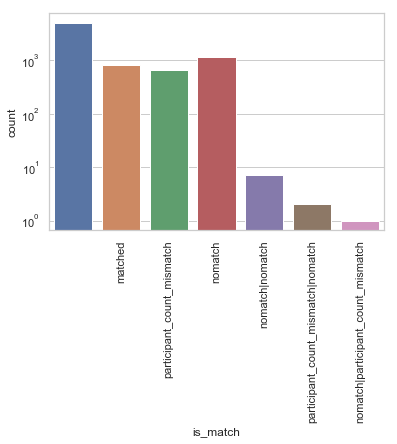

In [59]:
g = sns.countplot(x="is_match", data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_yscale('log')

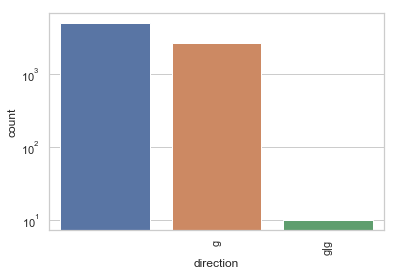

In [62]:
g = sns.countplot(x="direction", data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_yscale('log')

## Sample of GO-Rhea xrefs whose formulae don't match


In [60]:
df.loc[df['is_match'] == 'nomatch']

,class,class label,def,op,goleft,goright,rhea,rhea label,direction,is_match,score,info,info label
31,GO:0047820,D-glutamate cyclase activity,Catalysis of the reaction: D-glutamate = 5-oxo...,=,http://purl.obolibrary.org/obo/CHEBI_29986/D-g...,http://purl.obolibrary.org/obo/CHEBI_16924/5-o...,rh:22360,D-glutamate = 5-oxo-D-proline + H2O,g,nomatch,-987,http://purl.obolibrary.org/obo/CHEBI_15377|htt...,water|D-glutamate(1-)|5-oxo-D-prolinate
45,GO:0004800,thyroxine 5'-deiodinase activity,"Catalysis of the reaction: 3,5,3'-L-triiodo-L-...",=,"http://x.org/noparse#3,5,3'-L-triiodo-L-thyron...",http://purl.obolibrary.org/obo/CHEBI_18332/L-t...,rh:19745,"3,3',5-triiodo-L-thyronine + A + H(+) + iodide...",g,nomatch,-1013,http://purl.obolibrary.org/obo/CHEBI_13193|htt...,hydrogen acceptor|hydron|iodide|hydrogen donor...
177,GO:0016852,sirohydrochlorin cobaltochelatase activity,Catalysis of the reaction: sirohydrochlorin + ...,=,http://purl.obolibrary.org/obo/CHEBI_18023/sir...,http://purl.obolibrary.org/obo/CHEBI_52491/cob...,rh:15893,Co-sirohydrochlorin + 2 H(+) = Co(2+) + sirohy...,g,nomatch,-932,http://purl.obolibrary.org/obo/CHEBI_15378|htt...,hydron|cobalt(2+)|sirohydrochlorin(8-)|cobalt-...
182,GO:0047720,indoleacetaldoxime dehydratase activity,Catalysis of the reaction: (indol-3-yl)acetald...,=,http://purl.obolibrary.org/obo/CHEBI_28311/ind...,http://purl.obolibrary.org/obo/CHEBI_17566/ind...,rh:23156,(E)-(indol-3-yl)acetaldehyde oxime = (indol-3-...,g,nomatch,-988,http://purl.obolibrary.org/obo/CHEBI_15377|htt...,water|(E)-indol-3-ylacetaldehyde oxime|indole-...
192,GO:0043800,hexulose-6-phosphate isomerase activity,Catalysis of the reaction: D-arabino-3-hexulos...,=,http://x.org/noparse#D-arabino-3-hexulose 6-ph...,http://purl.obolibrary.org/obo/CHEBI_78697/D-f...,rh:25900,D-arabino-hex-3-ulose 6-phosphate = beta-D-fru...,g,nomatch,-1040,http://purl.obolibrary.org/obo/CHEBI_57634|htt...,beta-D-fructofuranose 6-phosphate(2-)|D-arabin...
212,GO:0018489,vanillate monooxygenase activity,Catalysis of the reaction: H(+) + NADH + O(2) ...,=,http://purl.obolibrary.org/obo/CHEBI_15378/hyd...,"http://purl.obolibrary.org/obo/CHEBI_36241/3,4...",rh:13021,4-hydroxy-3-methoxybenzoate + H(+) + NADH + O2...,g,nomatch,-985.5,http://purl.obolibrary.org/obo/CHEBI_15377|htt...,water|hydron|dioxygen|vanillate|formaldehyde|3...
339,GO:0018690,4-methoxybenzoate monooxygenase (O-demethylati...,Catalysis of the reaction: 4-methoxybenzoate +...,=,http://purl.obolibrary.org/obo/CHEBI_16639/4-m...,http://purl.obolibrary.org/obo/CHEBI_17879/4-h...,rh:18613,4-methoxybenzoate + AH2 + O2 = 4-hydroxybenzoa...,g,nomatch,-1031.3333333333333,http://purl.obolibrary.org/obo/CHEBI_13193|htt...,hydrogen acceptor|water|dioxygen|4-methoxybenz...
345,GO:0047096,"androst-4-ene-3,17-dione monooxygenase activity",Catalysis of the reaction: AH(2) + androst-4-e...,=,http://x.org/noparse#AH(2)/AH(2)-1|http://purl...,http://purl.obolibrary.org/obo/CHEBI_13193/hyd...,rh:22696,"AH2 + androst-4-ene-3,17-dione + O2 = A + H2O ...",g,nomatch,-1040.6666666666667,http://purl.obolibrary.org/obo/CHEBI_13193|htt...,hydrogen acceptor|water|dioxygen|androst-4-ene...
346,GO:0047097,"phylloquinone monooxygenase (2,3-epoxidizing) ...",Catalysis of the reaction: AH(2) + O(2) + phyl...,=,http://x.org/noparse#AH(2)/AH(2)-1|http://x.or...,"http://purl.obolibrary.org/obo/CHEBI_15759/2,3...",rh:16745,"AH2 + O2 + phylloquinone = 2,3-epoxyphylloquin...",g,nomatch,-1040.6666666666667,http://purl.obolibrary.org/obo/CHEBI_13193|htt...,"hydrogen acceptor|water|dioxygen|2,3-epoxyphyl..."
347,GO:0047546,2-hydroxypyridine 5-monooxygenase activity,Catalysis of the reaction: 2-hydroxypyridine +...,=,http://purl.obolibrary.org/obo/CHEBI_16540/pyr...,http://purl.obolibrary.org/obo/CHEBI_16364/pyr...,rh:16973,"2-hydroxypyridine + AH2 + O2 = 2,5-dihydroxypy...",g,nomatch,-1042,http://purl.obolibrary.org/obo/CHEBI_13193|htt...,"hydrogen acceptor|water|dioxygen|pyridine-2,5-..."


In [53]:
df.loc[df['class'] == 'GO:0047805']

,class,class label,def,op,goleft,goright,rhea,rhea label,is_match,score,info,info label
30,GO:0047805,cytidylate cyclase activity,"Catalysis of the reaction: CTP = 3',5'-cyclic ...",=,http://purl.obolibrary.org/obo/CHEBI_17677/CTP-1,"http://purl.obolibrary.org/obo/CHEBI_17065/3',...",rh:14737,"CTP = 3',5'-cyclic CMP + diphosphate",nomatch,-931.3333333333334,http://purl.obolibrary.org/obo/CHEBI_33019|htt...,"diphosphate(3-)|CTP(4-)|3',5'-cyclic CMP(1-)"


Take the first example (adenylate cyclase activity). We would hope that 

## Chemical names that cannot be parsed in GO text definitions



In [34]:
df = pd.read_csv("reports/chebi-no-match.tsv", sep="\t").fillna("")
## Show sample
df

,class,class label,def,unmatched_term,rhea_chebi_id,rhea_chebi_id label,info,score,rhea,ec,metacyc
0,GO:0004453,juvenile-hormone esterase activity,"Catalysis of the reaction: methyl (2E,6E)-(10R...","methyl (2E,6E)-(10R,11S)-10,11-epoxy-3,7,11-tr...",,,,,,,
1,GO:0000298,endopolyphosphatase activity,Catalysis of the reaction: polyphosphate + n H...,n H2O,,,,,,,
2,GO:0000298,endopolyphosphatase activity,Catalysis of the reaction: polyphosphate + n H...,(n+1) oligophosphate,,,,,,,
3,GO:0047388,[glutamine synthetase]-adenylyl-L-tyrosine pho...,Catalysis of the reaction: adenylyl-[L-glutama...,adenylyl-[L-glutamate:ammonia ligase (ADP-form...,,,,,,,
4,GO:0047388,[glutamine synthetase]-adenylyl-L-tyrosine pho...,Catalysis of the reaction: adenylyl-[L-glutama...,[L-glutamate:ammonia ligase (ADP-forming)],,,,,,,
5,GO:0047388,[glutamine synthetase]-adenylyl-L-tyrosine pho...,Catalysis of the reaction: adenylyl-[L-glutama...,adenylyl-[L-glutamate:ammonia ligase (ADP-form...,,,,,,,
6,GO:0047388,[glutamine synthetase]-adenylyl-L-tyrosine pho...,Catalysis of the reaction: adenylyl-[L-glutama...,[L-glutamate:ammonia ligase (ADP-forming)],,,,,,,
7,GO:0047388,[glutamine synthetase]-adenylyl-L-tyrosine pho...,Catalysis of the reaction: adenylyl-[L-glutama...,adenylyl-[L-glutamate:ammonia ligase (ADP-form...,,,,,,,
8,GO:0047388,[glutamine synthetase]-adenylyl-L-tyrosine pho...,Catalysis of the reaction: adenylyl-[L-glutama...,[L-glutamate:ammonia ligase (ADP-forming)],,,,,,,
9,GO:0018657,toluene 3-monooxygenase activity,Catalysis of the reaction: toluene + 1/2 O2 = ...,1/2 O2,,,,,,,


**TODO**: implement tokenization so `H(2)O` matches CHEBI `H2O`

### Count plot of number of usages of unparsed terms

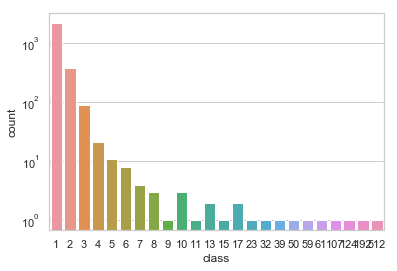

In [35]:
agg_df = df.groupby("unmatched_term").agg({"class": pd.Series.nunique})
g = sns.countplot(x="class", data=agg_df)
g.set_yscale('log')

### All unparsed chemical names used more than ten times

In [36]:
agg_df.loc[agg_df['class'] > 10]

,class
unmatched_term,
1/2 O2,23
AH(2),39
CO(2),124
H(2)O,512
H(2)O(2),50
NAD(P)+,107
NH(4)(+),59
O(2),192
S-adenosyl-L-methionine(1+),32


Some of these are due to lack of tokenization in parsing (CHEBI has `H2O` but not `H(2)O`), lack of synonyms in CHEBI (e.g. `CHEBI:37240` `adenosine 3',5'-bisphosphate` but no syns), or issues in parsing the GO text def